In [2]:
import json
import warnings
import numpy as np
from tqdm import tqdm
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

In [3]:
def construct_matrix(data_path):
    f = open(data_path, 'r')
    data = json.load(f)
    f.close()
    training_list = []
    target_list = []
    for category in data:
        target = np.zeros(len(data[category]))
        matrix = np.zeros((len(data[category]),100))
        for n,item in enumerate(data[category]):
            matrix[n] = np.array(item['hist'])
            target[n] = item['age']
        training_list.append(matrix)
        target_list.append(target)
    training_matrix = np.concatenate(training_list)
    target = np.concatenate(target_list)
    return training_matrix, target

In [4]:
def linear_regression_split_by_hospital(data_path):
    f = open(data_path, 'r')
    data = json.load(f)
    f.close()
    loss_list = []
    for test_category in data:
        X_test = np.zeros((len(data[test_category]), 100))
        y_test = np.zeros(len(data[test_category]))
        for n,item in enumerate(data[test_category]):
            X_test[n] = np.array(item['hist'])
            y_test[n] = np.array(item['age'])
        train_list = []
        target_list = []
        for train_category in data:
            if train_category != test_category:
                matrix = np.zeros((len(data[train_category]), 100))
                target = np.zeros(len(data[train_category]))
                for n,item in enumerate(data[train_category]):
                    matrix[n] = np.array(item['hist'])
                    target[n] = item['age']
                train_list.append(matrix)
                target_list.append(target)
                
        X_train = np.concatenate(train_list)
        y_train = np.concatenate(target_list)
        model = GaussianProcessRegressor()
        model.fit(X_train, y_train)
        predict_y = model.predict(X_test)
        loss = np.mean(np.abs(y_test - predict_y))
        loss_list.append(loss)
        print(f'Loss for {test_category} = {loss}')
    print(f'Average loss = {np.mean(loss_list)}')
    return np.mean(loss_list)
    
    

In [5]:
def simple_linear_regression(X, y,k=10):
    kf = KFold(n_splits=k)
    split_result = kf.split(X)
    loss_array = np.zeros(k)
    for n,(train, test) in tqdm(enumerate(split_result),total=k):
        X_train = X[train]
        X_test = X[test]
        y_train = y[train]
        y_test = y[test]
        model = LinearRegression()
        model.fit(X_train, y_train)
        predict_y = model.predict(X_test)
        loss = np.mean(np.abs(y_test - predict_y))
        loss_array[n] = loss
    return loss_array.mean()

In [6]:
def gaussian_process_regression(X,y,k=10):
    kf = KFold(n_splits=k)
    split_result = kf.split(X)
    loss_array = np.zeros(k)
    for n,(train, test) in tqdm(enumerate(split_result),total=k):
        X_train = X[train]
        X_test = X[test]
        y_train = y[train]
        y_test = y[test]
        model = GaussianProcessRegressor()
        model.fit(X_train, y_train)
        predict_y = model.predict(X_test)
        loss = np.mean(np.abs(y_test - predict_y))
        loss_array[n] = loss
    return loss_array.mean()

In [7]:
def PolynomialLinearRegression(X,y,k=10):
    kf = KFold(n_splits=k)
    split_result = kf.split(X)
    loss_array = np.zeros(k)
    for n,(train, test) in tqdm(enumerate(split_result),total=k):
        X_train = X[train]
        X_test = X[test]
        y_train = y[train]
        y_test = y[test]
        model = LinearRegression()
        poly = PolynomialFeatures(degree=1)
        X_train = poly.fit_transform(X_train)
        model.fit(X_train, y_train)
        X_test =  poly.fit_transform(X_test)
        predict_y = model.predict(X_test)
        loss = np.mean(np.abs(y_test - predict_y))
        loss_array[n] = loss
    return loss_array.mean()


In [8]:
def random_forest(X,y,k=10):
    kf = KFold(n_splits=k)
    split_result = kf.split(X)
    loss_array = np.zeros(k)
    for n,(train, test) in tqdm(enumerate(split_result),total=k):
        X_train = X[train]
        X_test = X[test]
        y_train = y[train]
        y_test = y[test]
        model = RandomForestRegressor()
        model.fit(X_train,y_train)
        predict_y = model.predict(X_test)
        loss = np.mean(np.abs(y_test - predict_y))
        loss_array[n] = loss
    return loss_array,model

In [24]:
# 2:GMM
# 3:WhiteStripe
# 4:Homemade

X,y = construct_matrix('data_representation/rep2.json')
result = random_forest(X,y)
k = 10
kf = KFold(n_splits=10)
split_result = kf.split(X)
loss_array = np.zeros(k)
test_array = np.array([])
predict_array = np.array([])
for n,(train, test) in tqdm(enumerate(split_result),total=k):
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]
    model = RandomForestRegressor()
    model.fit(X_train,y_train)
    predict_y = model.predict(X_test)
    loss = np.mean(np.abs(y_test - predict_y))
    predict_array = np.concatenate((predict_array, predict_y))
    test_array = np.concatenate((test_array, y_test))
    loss_array[n] = loss

100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


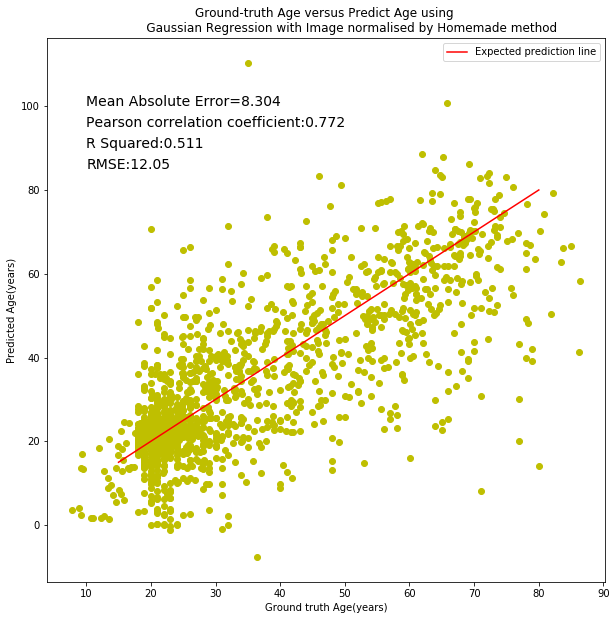

In [179]:
plt.figure(figsize=(10,10))
p_value = pearsonr(test_array,predict_array)
rmse = np.sqrt(mean_squared_error(test_array, predict_array))
r2 = r2_score(test_array, predict_array)
plt.scatter(test_array,predict_array,c='y')
plt.xlabel('Ground truth Age(years)')
plt.ylabel('Predicted Age(years)')
plt.title('Ground-truth Age versus Predict Age using \n \
            Gaussian Regression with Image normalised by Homemade method')
plt.plot(np.linspace(15,80,100),np.linspace(15,80,100), c='r', label='Expected prediction line')
offset = 20
plt.text(10, 80+offset, f'Mean Absolute Error={round(loss_array.mean(),3)}',fontsize=14)
plt.text(10, 75+offset, f'Pearson correlation coefficient:{round(p_value[0],3)}',fontsize=14)
plt.text(10, 70+offset, f'R Squared:{round(r2,3)}',fontsize=14)
plt.text(10, 65+offset, f'RMSE:{round(rmse,3)}',fontsize=14)
# plt.text(10, 120-150, f'Mean Absolute Error={round(loss_array.mean(),3)}',fontsize=14)
# plt.text(10, 110-150, f'Pearson correlation coefficient:{round(p_value[0],3)}',fontsize=14)
# plt.text(10, 100-150, f'R Squared:{round(r2,3)}',fontsize=14)
# plt.text(10, 90-150, f'RMSE:{round(rmse,3)}',fontsize=14)
plt.legend()
plt.show()

In [10]:
import matplotlib.pyplot as plt

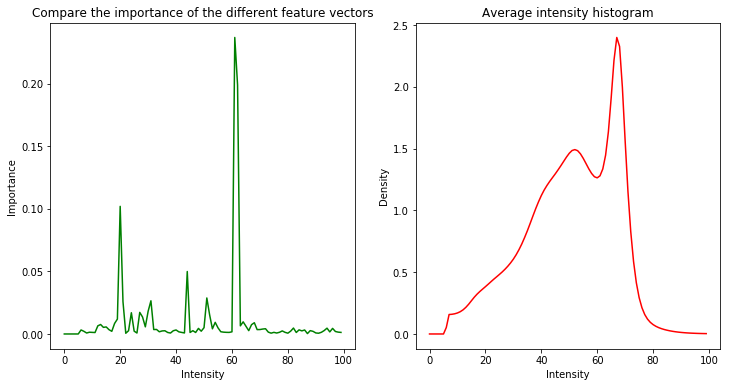

In [25]:
plt.figure(figsize=(12,6))
x_mean = X_train.mean(axis=0)
plt.subplot(1,2,1)
plt.title('Compare the importance of the different feature vectors')
plt.plot(model.feature_importances_,c='g')
plt.xlabel('Intensity')
plt.ylabel('Importance')
plt.subplot(1,2,2)
plt.title('Average intensity histogram')
plt.plot(x_mean,c='r')
plt.xlabel('Intensity')
plt.ylabel('Density')
plt.show()

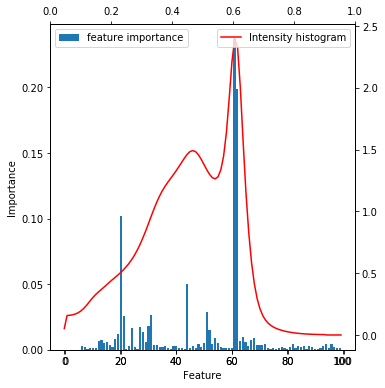

In [191]:
from pylab import *

plt.figure(figsize=(12,6))
x_mean = X_train.mean(axis=0)
plt.subplot(1,2,1)
plt.bar(range(len(model.feature_importances_)),model.feature_importances_, label='feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
legend(loc=2)
twinx()
twiny()
new_x_mean = np.zeros(len(x_mean))
for index in range(len(x_mean)):
    if index < 94:
        new_x_mean[index] = x_mean[index+6]
    else:
        new_x_mean[index] = 0

plt.plot(new_x_mean,c='r', label='Intensity histogram')
plt.ylabel('Intensity')
legend(loc=1)
twiny()

plt.show()

In [168]:
import nibabel as nib
obj = np.array(nib.load('training_set/GMM/X/0.nii.gz').dataobj)

In [52]:
value, grid = np.histogram(obj[obj>0], density=True, bins=np.linspace(0,1.5,101))

In [60]:
np.argsort(model.feature_importances_)

array([ 0,  1,  2,  3,  4,  5, 87, 22, 91, 80, 74, 38, 76, 26,  8, 90, 43,
       11, 45, 83, 37, 47, 42, 59, 99, 10, 75, 79, 58, 77, 92,  9, 57, 98,
       73, 95, 41, 60, 34, 56, 97, 89, 17,  7, 49, 25, 81, 35, 78, 85, 36,
       39, 23, 46, 66, 88, 93, 86, 40,  6, 84, 16, 69, 32, 70, 33, 71, 53,
       72, 48, 96, 94, 82, 55, 50, 14, 15, 29, 65, 63, 12, 67, 13, 18, 68,
       54, 64, 19, 28, 52, 24, 27, 30, 21, 31, 51, 44, 20, 62, 61])

In [69]:
model.feature_importances_[62]

0.19883094688460254

In [179]:
grid[61],grid[62],grid[19],grid[20],grid[21],grid[44],

(0.9149999999999999, 0.9299999999999999, 0.285, 0.3, 0.315, 0.6599999999999999)

In [97]:
def show(obj):
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.imshow(obj[:,:,80])
    plt.subplot(1,3,2)
    plt.imshow(obj[:,70,:])
    plt.subplot(1,3,3)
    plt.imshow(obj[50,:,:])

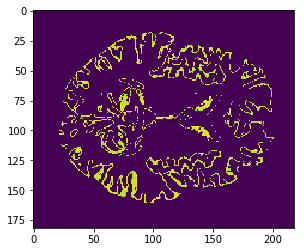

In [177]:
import copy
data = copy.copy(obj)
data[(data<0.6)] = 0
data[(data>0.7)] = 0
plt.imshow(data[:,:,80])

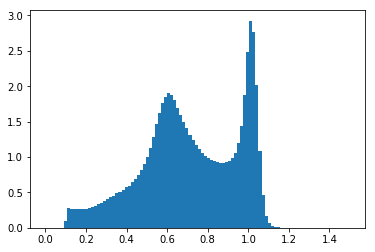

In [105]:
_ = plt.hist(obj[obj>0],density=True, bins=np.linspace(0,1.5,101))

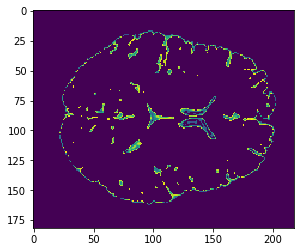

In [142]:

plt.imshow(data[:,:,85])

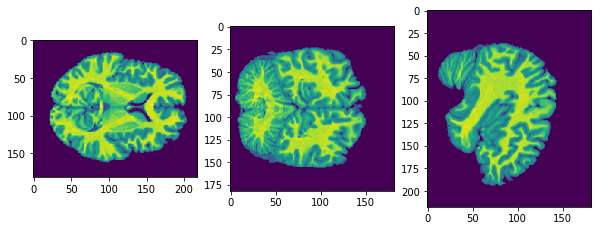

In [139]:
show(obj)

In [150]:
import PIL


In [156]:
import cv2


In [152]:
image=data[:,:,85]

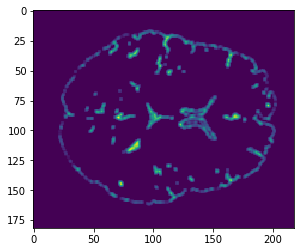

In [163]:
plt.imshow(cv2.GaussianBlur(image,(3,3),1.5))